# Credit Card Fraud Detection
1. The objective is to identify fraudulent credit card transactions using predictor variables.
2. This dataset is available at [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud).

3. The following description of the dataset is directly copied from Kaggle:

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

##### Please note that in this notebook we will deal with the imbalanced class problem by assigning greater weight to the fraudulent cases so that the classifiers penalize fraudulent transactions misclassified as legitimate more as compared to legitimate transactions misclassified as fraud. We will utilize over/under sampling methods or treat the classification problem as an anomaly detection problem in subsequent notebooks.

## Step 1: Loading libraries to be used in the modeling, loading the dataset, and initial exploratory analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print('numpy version: ',np.__version__)
print('pandas version: ',pd.__version__)
print('seaborn version: ',sns.__version__)

numpy version:  1.18.1
pandas version:  1.0.0
seaborn version:  0.10.0


In [2]:
#loading the data from the csv file downloaded from Kaggle
#the link is provided in the first markdown cell

data = pd.read_csv('datasets/credit-card-fraud.csv', header='infer')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#dimension of the dataset

data.shape

(284807, 31)

In [4]:
#checking to see whether we have any missing values among features: No, there are not.

data.columns[data.isnull().any()]

Index([], dtype='object')

In [5]:
#getting the counts for the response variable.
#492 fraudulent transactions among 284,807 as indicated in the description of the dataset

data.groupby('Class').size()

Class
0    284315
1       492
dtype: int64

In [6]:
#separating the predictor variables and the response variable

X = data.iloc[:, 0:30]
y = data.loc[:, 'Class']

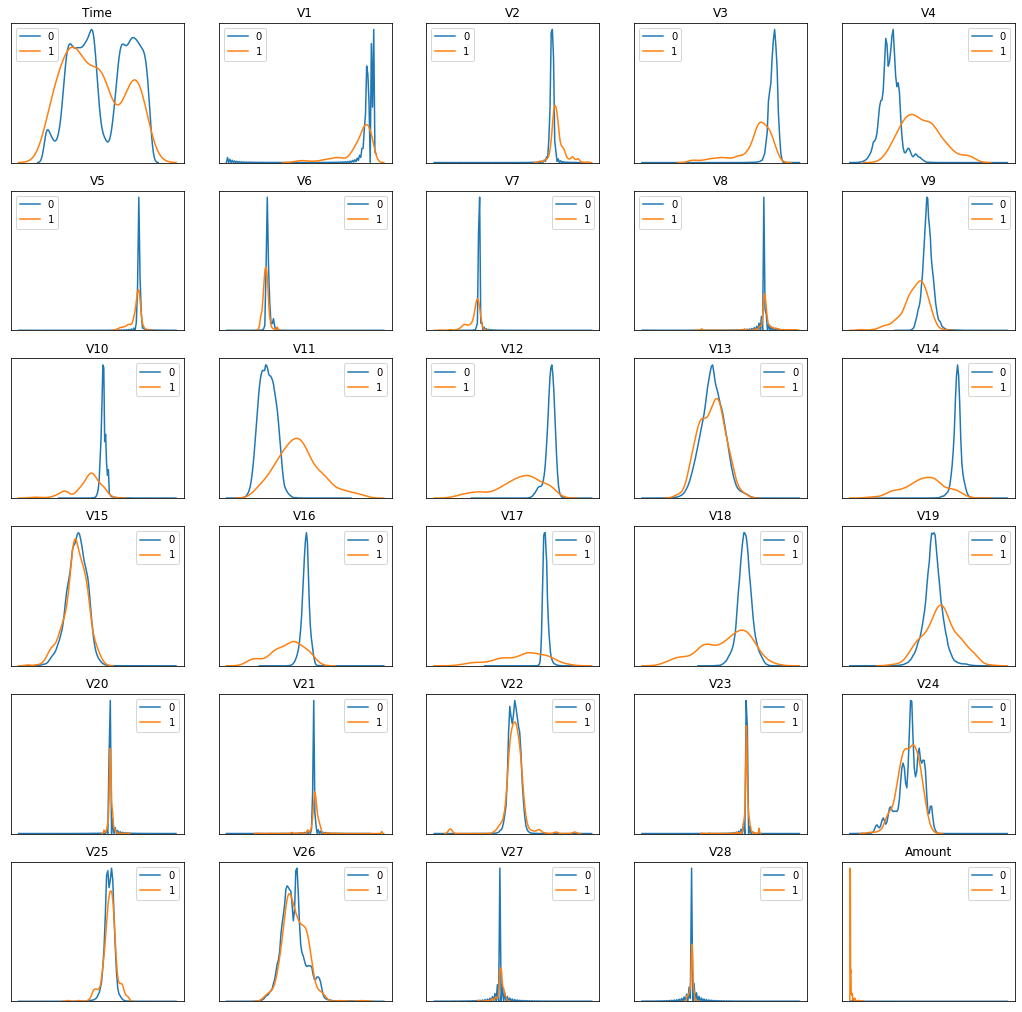

In [7]:
#distribution of each predictor variable grouped by the response variable.

plt.figure(figsize=(18,18))

for k in range(0,30):
    plt.subplot(6, 5, k+1)
    sns.kdeplot(X.loc[(y == 0), X.columns[k]], label='0')
    sns.kdeplot(X.loc[(y == 1),X.columns[k]], label='1')
    plt.title(X.columns[k])
    plt.xticks([])
    plt.yticks([])

plt.legend()
plt.show()

#### Observations:
1. This dataset contains transactions over a two day time period. The distribution of legitimate transactions reflect this periodocity quite well. The fraudulent ones less so.
2. There are no missing values in the dataset.
3. The fraudulent transactions constitute a mere 0.172% of all transactions; hence, the classes exhibit gross imbalance.

## Step 2: Splitting the data into training and test sets

In [8]:
#setting the random seed for reproducibility
random_seed = 2020

In [9]:
# I am setting 33.3% data aside for the test set.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, stratify=y, random_state=random_seed)

In [10]:
#sanity check (ensuring that sizes match)

(X_train.shape[0] + X_test.shape[0] == X.shape[0],
 y_train.size + y_test.size == y.size)

(True, True)

In [11]:
#sanity check 2 (ensuring that data is split in a stratified way)

print('Fradulent transactions in the train set: ', y_train.sum())
print('Fradulent transactions in the test set: ', y_test.sum())

Fradulent transactions in the train set:  328
Fradulent transactions in the test set:  164


#### Notes:
1. I assigned $\frac{2}{3}$ of the data to the training set and the remaining $\frac{1}{3}$ to the test set.
2. The data is split in a stratified way to ensure equidistribution of the response variable in both sets.

## Step 3: Trying various algorithms straight out of box

According to "No Free Lunch Theorem", there is no universal algorithm which outperforms all other methods. Equivalently, if you make no assumptions about the data, then there is no reason to prefer one model over any other. Thus, I will try a good number of models on the dataset and pick top performers for further study.

Since the response variable shows gross imbalance between classes, it will be pointless to compare models using 'accuracy' as the metric. (Accuracy is the percentage of instances correctly classified). Even the dummy classifier which assigns 'not fraudulent' label to all instances will have an accuracy score of 99.828%. As a result, we will use 'average precision' as the metric.

Moreover, we will assign greater weight to the fraudulent cases while initializing the models so that the classifiers penalize fraudulent transactions misclassified as legitimate more as compared to other way around.

#### Average Precision (explanation copied from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score))
Average Precision (AP) summarizes the precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:
$$
AP = \sum_n (R_n - R_{n-1}) P_n
$$
where $P_n$ and $R_n$ are the precision and recall at the nth threshold. This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

### Models that do NOT need scaling

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, 
                              BaggingClassifier, 
                              ExtraTreesClassifier, 
                              GradientBoostingClassifier,
                              RandomForestClassifier)
import lightgbm as lgb

base_estimator = DecisionTreeClassifier(class_weight='balanced', random_state=random_seed)
models_ensemble = [
    ('ADA', AdaBoostClassifier(base_estimator=base_estimator, random_state=random_seed)),
    ('Bag', BaggingClassifier(base_estimator=base_estimator, random_state=random_seed)),
    ('ETsC', ExtraTreesClassifier(class_weight='balanced', random_state=random_seed)),
    ('GBC', GradientBoostingClassifier(random_state=random_seed)),
    ('RFC', RandomForestClassifier(class_weight='balanced', random_state=random_seed))
]
models_lgbm = [('lgbm', lgb.LGBMClassifier(class_weight='balanced', random_state=random_seed))]
models_need_NO_scaling = models_ensemble + models_lgbm

In [13]:
from sklearn.model_selection import cross_val_score

models = models_need_NO_scaling
cv = 5
scoring = 'average_precision'

cv_results = {}

for name, model in models:
    cv_res = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, verbose=2, n_jobs=-1)
    cv_results[name] = cv_res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   37.1s remaining:   55.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   27.0s remaining:   40.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

In [14]:
results_df = pd.DataFrame(cv_results, index=range(1, cv+1))

In [15]:
results_df.mean(axis='index').sort_values()

GBC     0.553795
ADA     0.554389
Bag     0.785648
lgbm    0.821711
RFC     0.838706
ETsC    0.845056
dtype: float64

In [16]:
results_df.std(axis='index')

ADA     0.035093
Bag     0.033022
ETsC    0.022867
GBC     0.193792
RFC     0.020281
lgbm    0.048898
dtype: float64

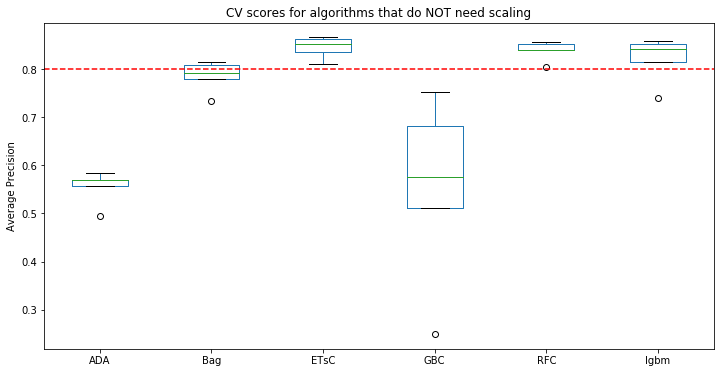

In [17]:
results_df.plot(kind='box', figsize=(12, 6))
plt.title('CV scores for algorithms that do NOT need scaling')
plt.axhline(y=0.8, color='red', linestyle='dashed')
plt.ylabel('Average Precision')
plt.show()

### Models that need scaling

In [18]:
from sklearn.linear_model import (LogisticRegression, 
                                  PassiveAggressiveClassifier, 
                                  RidgeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models_lin = [
    ('Log_Reg', LogisticRegression(class_weight='balanced', random_state=random_seed)),
    ('PAC', PassiveAggressiveClassifier(class_weight='balanced', random_state=random_seed)),
    ('Ridge', RidgeClassifier(class_weight='balanced', random_state=random_seed))
]
model_neigh = [('KNC', KNeighborsClassifier(weights='distance'))]
model_svm = [('SVC', SVC(class_weight='balanced', random_state=random_seed))]

models_need_scaling = models_lin + model_neigh + model_svm

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

models_sc = models_need_scaling
cv = 5
scoring = 'average_precision'

cv_results_sc = {}

for name, model in models_sc:
    model_pip = Pipeline([
        ('scaler', StandardScaler()),
        (name, model)
    ])
    cv_res = cross_val_score(model_pip, X_train, y_train, cv=cv, scoring=scoring, verbose=2, n_jobs=-1)
    cv_results_sc[name] = cv_res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

In [20]:
results_df_sc = pd.DataFrame(cv_results_sc, index=range(1, cv+1))

In [21]:
results_df_sc.mean(axis='index').sort_values()

Ridge      0.229538
SVC        0.582524
PAC        0.703971
Log_Reg    0.730222
KNC        0.811930
dtype: float64

In [22]:
results_df_sc.std(axis='index')

Log_Reg    0.048464
PAC        0.035741
Ridge      0.019457
KNC        0.042974
SVC        0.046465
dtype: float64

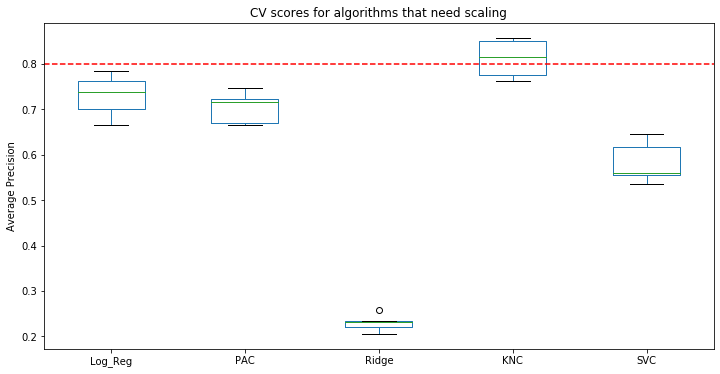

In [23]:
results_df_sc.plot(kind='box', figsize=(12, 6))
plt.title('CV scores for algorithms that need scaling')
plt.axhline(y=0.8, color='red', linestyle='dashed')
plt.ylabel('Average Precision')
plt.show()

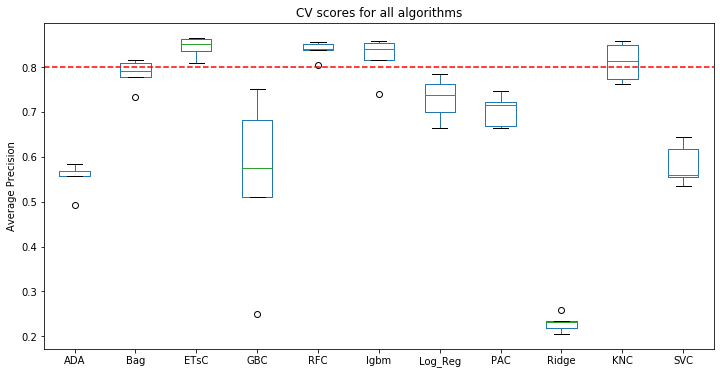

In [24]:
results = pd.concat([results_df, results_df_sc], axis='columns')

results.plot(kind='box', figsize=(12, 6))
plt.title('CV scores for all algorithms')
plt.axhline(y=0.8, color='red', linestyle='dashed')
plt.ylabel('Average Precision')
plt.show()

#### Results:
The following algorithms deserve further study:
1. ETsC: Extra Trees Classifier
2. RFC: Random Forest Classifier
3. lgbm: LGBMClassifier
4. KNC: K-Neigbors Classifier

## Step 4: Fine tuning of promising algorithms
We will fine-tune (find optimal hyperparameters) for the promising algorithms using 5-fold cross validation with respect to 'average precision'.

In [25]:
from sklearn.model_selection import GridSearchCV

### KNC: K-Neighbors Classifier

In [26]:
neighbors = list(range(1, 7))  #default=5, bias decreases as it decreases
par_grid_KNC = dict(KNC__n_neighbors=neighbors)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('KNC', KNeighborsClassifier(weights='distance'))
])

grid_KNC = GridSearchCV(estimator=model, param_grid=par_grid_KNC, cv=cv, 
                        verbose=2, n_jobs=-1, scoring=scoring)
grid_result_KNC = grid_KNC.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 26.1min finished


In [27]:
grid_result_KNC.best_params_

{'KNC__n_neighbors': 6}

In [28]:
grid_result_KNC.best_score_

0.8138489099618436

In [29]:
pd.DataFrame(grid_result_KNC.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
5,{'KNC__n_neighbors': 6},0.813849,0.041682,1
4,{'KNC__n_neighbors': 5},0.811930,0.038437,2
3,{'KNC__n_neighbors': 4},0.799866,0.032908,3
2,{'KNC__n_neighbors': 3},0.795773,0.030448,4
1,{'KNC__n_neighbors': 2},0.774084,0.023871,5
0,{'KNC__n_neighbors': 1},0.680464,0.040433,6


#### The best estimator is with n_neighbors=6

### ETsC: Extra Trees Classifier

In [30]:
n_estimators = [100, 125, 150, 200]   #default=100, bias increases as it decreases

par_grid_X_tree = dict(n_estimators=n_estimators)

model = ExtraTreesClassifier(class_weight='balanced', random_state=random_seed)

grid_X_tree = GridSearchCV(estimator=model, param_grid=par_grid_X_tree, cv=cv, 
                        verbose=2, n_jobs=-1, scoring=scoring)
grid_result_X_tree = grid_X_tree.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  2.4min remaining:   36.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.8min finished


In [31]:
grid_result_X_tree.best_params_

{'n_estimators': 150}

In [32]:
grid_result_X_tree.best_score_

0.8474983986563641

In [33]:
pd.DataFrame(grid_result_X_tree.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
2,{'n_estimators': 150},0.847498,0.022549,1
3,{'n_estimators': 200},0.847482,0.021372,2
1,{'n_estimators': 125},0.846569,0.021150,3
0,{'n_estimators': 100},0.845056,0.020453,4


#### The best estimator is with n_estimators=200
Even though the estimator with n_estimators=150 has an average score which is marginally better, the one with n_estimators=200 has lower variance.

### RFC: Random Forest Classifier

In [34]:
n_estimators = [100, 125, 150, 200]   #default=100, bias increases as it decreases
par_grid_rfc = dict(n_estimators=n_estimators)

model = RandomForestClassifier(class_weight='balanced', random_state=random_seed)

grid_rfc = GridSearchCV(estimator=model, param_grid=par_grid_rfc, cv=cv, 
                        verbose=2, n_jobs=-1, scoring=scoring)
grid_result_rfc = grid_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  5.4min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  6.8min finished


In [35]:
grid_result_rfc.best_params_

{'n_estimators': 200}

In [36]:
grid_result_rfc.best_score_

0.84220182762009

In [37]:
pd.DataFrame(grid_result_rfc.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
3,{'n_estimators': 200},0.842202,0.018141,1
2,{'n_estimators': 150},0.842010,0.017236,2
1,{'n_estimators': 125},0.839767,0.017544,3
0,{'n_estimators': 100},0.838706,0.018140,4


#### The best estimator is with n_estimators=150
Even though the estimator with n_estimators=200 has an average score which is marginally better, the one with n_estimators=150 has lower variance.

### lgbm: LGBMClassifier

In [38]:
n_estimators = [100, 125, 150, 200]   #default=100, bias increases as it decreases
learning_rate = [0.05, 0.1, 0.2, 0.3, 0.5]    #default=0.1, bias increases as it increases
par_grid_lgbm = dict(n_estimators=n_estimators, learning_rate=learning_rate)

model = lgb.LGBMClassifier(class_weight='balanced', random_state=random_seed)

grid_lgbm = GridSearchCV(estimator=model, param_grid=par_grid_lgbm, cv=cv, 
                        verbose=2, n_jobs=-1, scoring=scoring)
grid_result_lgbm = grid_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished


In [39]:
grid_result_lgbm.best_params_

{'learning_rate': 0.2, 'n_estimators': 150}

In [40]:
grid_result_lgbm.best_score_

0.8432741572399859

In [41]:
pd.DataFrame(grid_result_lgbm.cv_results_)[['params', 'mean_test_score', 
                                           'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(5)

,params,mean_test_score,std_test_score,rank_test_score
10,"{'learning_rate': 0.2, 'n_estimators': 150}",0.843274,0.025587,1
11,"{'learning_rate': 0.2, 'n_estimators': 200}",0.842680,0.025872,2
9,"{'learning_rate': 0.2, 'n_estimators': 125}",0.842416,0.027226,3
8,"{'learning_rate': 0.2, 'n_estimators': 100}",0.841377,0.028664,4
7,"{'learning_rate': 0.1, 'n_estimators': 200}",0.838449,0.029586,5


#### The best estimator is with n_estimators=150 and learning_rate=0.2

## Step 5: Evaluation of the tuned models on the test set

In [42]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve

### ETsC -- Extra Trees Classifier with n_estimators=200

In [43]:
x_tree = ExtraTreesClassifier(n_estimators=200, class_weight='balanced', random_state=random_seed, 
                              n_jobs=-1)
x_tree.fit(X_train, y_train)
preds = x_tree.predict_proba(X_test)
print('ETsC Average Precision Score: ', np.round(average_precision_score(y_test, preds[:, 1]), 5))

ETsC Average Precision Score:  0.84951


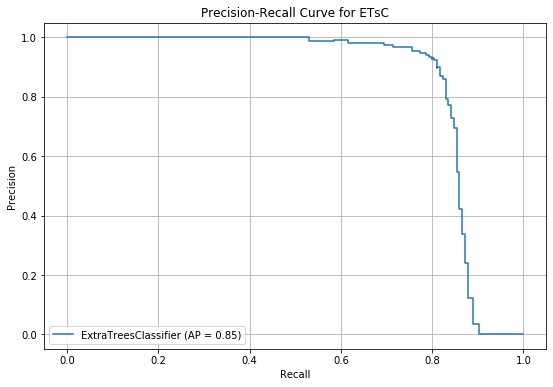

In [44]:
disp = plot_precision_recall_curve(x_tree, X_test, y_test)
disp.ax_.set_title('Precision-Recall Curve for ETsC')
disp.figure_.set_size_inches(9, 6)
plt.grid()
plt.show()

### RFC -- Random Forest Classifier with n_estimators=150

In [45]:
rfc = RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=random_seed,
                             n_jobs=-1)
rfc.fit(X_train, y_train)
preds = rfc.predict_proba(X_test)
print('RFC Average Precision Score: ', np.round(average_precision_score(y_test, preds[:, 1]), 5))

RFC Average Precision Score:  0.84819


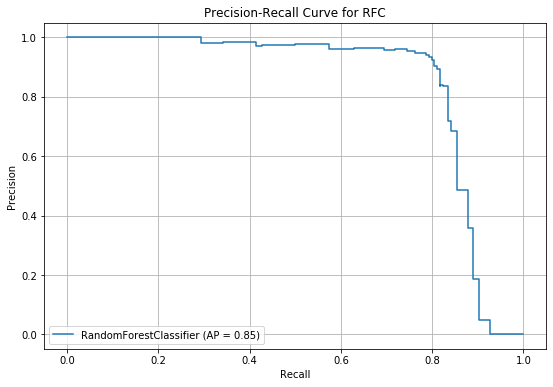

In [46]:
disp = plot_precision_recall_curve(rfc, X_test, y_test)
disp.ax_.set_title('Precision-Recall Curve for RFC')
disp.figure_.set_size_inches(9, 6)
plt.grid()
plt.show()

### KNC -- K-Neighbors Classifier with n_estimators=6

In [47]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

knc = KNeighborsClassifier(n_neighbors=6, weights='distance', n_jobs=-1)
knc.fit(X_train_sc, y_train)
preds = knc.predict_proba(X_test_sc)
print('KNC Average Precision Score: ', np.round(average_precision_score(y_test, preds[:, 1]), 5))

KNC Average Precision Score:  0.80995


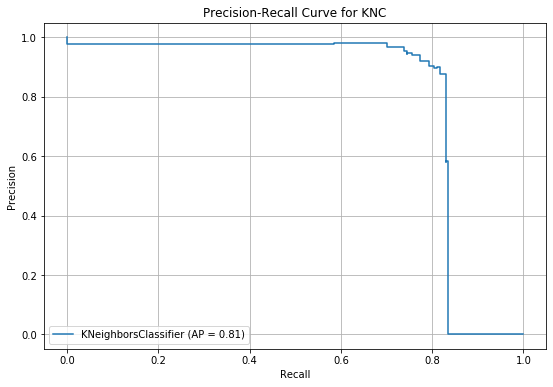

In [48]:
disp = plot_precision_recall_curve(knc, X_test_sc, y_test)
disp.ax_.set_title('Precision-Recall Curve for KNC')
disp.figure_.set_size_inches(9, 6)
plt.grid()
plt.show()

### lgbm -- LGBMClassifier with n_estimators=150 and learning_rate=0.2

In [49]:
lgbm = lgb.LGBMClassifier(class_weight='balanced', random_state=random_seed, n_estimators=150, 
                          learning_rate=0.2, n_jobs=-1)
lgbm.fit(X_train, y_train)
preds = lgbm.predict_proba(X_test)
print('lgbm Average Precision Score: ', np.round(average_precision_score(y_test, preds[:, 1]), 5))

lgbm Average Precision Score:  0.84353


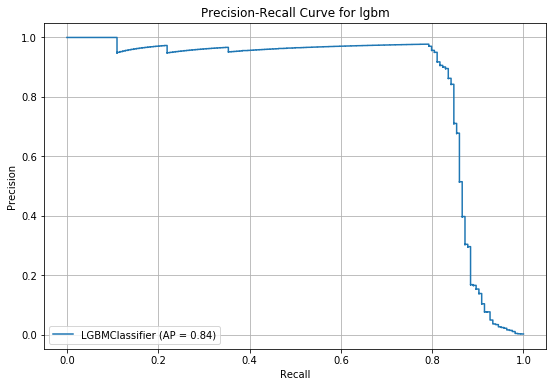

In [50]:
disp = plot_precision_recall_curve(lgbm, X_test, y_test)
disp.ax_.set_title('Precision-Recall Curve for lgbm')
disp.figure_.set_size_inches(9, 6)
plt.grid()
plt.show()

## Step 6: Conclusion
Based on the graph below, we deduce:

1. K-Neighbors Classifier is being dominated by other models for all desired levels of recall; therefore, it is the least useful model among the four.
2. One must pick a model based on the desired level of recall; for example, for 80% recall LGBMClassifier dominates all others. However, for 60% recall Extra Trees Classifier outperform others by a small margin.
3. One must decide on the desired level of recall based on business needs; nonetheless, 80% recall with almost perfect precision seems to be a sweet spot.

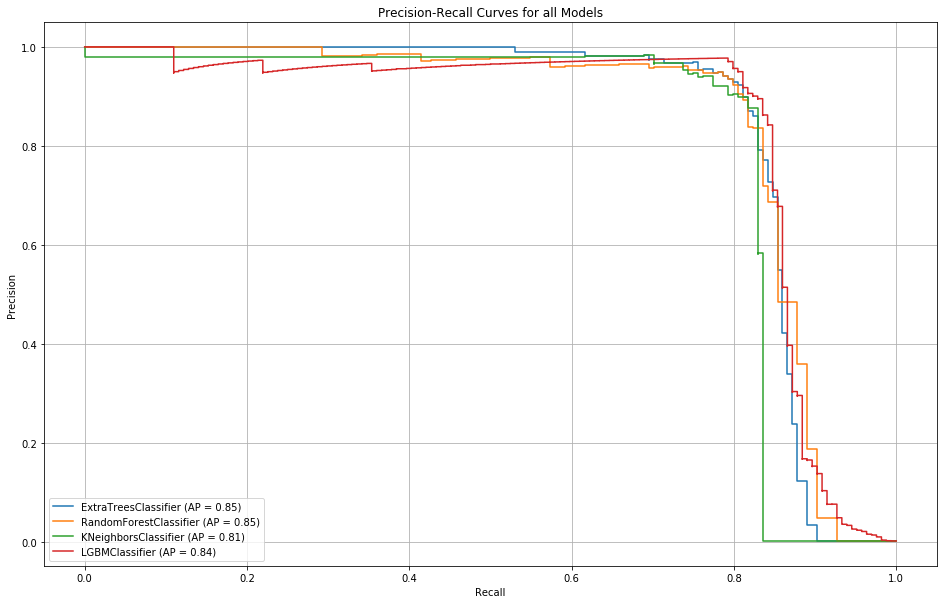

In [51]:
disp = plot_precision_recall_curve(x_tree, X_test, y_test)
plot_precision_recall_curve(rfc, X_test, y_test, ax=disp.ax_)
plot_precision_recall_curve(knc, X_test_sc, y_test, ax=disp.ax_)
plot_precision_recall_curve(lgbm, X_test, y_test, ax=disp.ax_)
disp.ax_.set_title('Precision-Recall Curves for all Models')
disp.figure_.set_size_inches(16, 10)
plt.grid()
plt.show()